### Overview of Library Imports

Here is a list of the primary Python libraries used within this project and their uses:

- **pandas, numpy**: numerical calculations and data manipulation.
- **os, random**: file system access and generation of random numbers.
- **joblib**: saving/loading large objects and models.
- **TfidfVectorizer & cosine_similarity:** text feature extraction and measurement of similarity
- **MinMaxScaler**: scales numeric data.
- **ndcg_score**: measures recommendation ranking quality.
- **Surprise: SVD, Dataset, Reader, accuracy**: Collaborative filtering and evaluation tools.
- **train_test_split (Surprise)**: separates the data for
- **defaultdict**: a dictionary with a default value. 
- **matplotlib, seaborn**: libraries for data visualization.

In [2]:
import pandas as pd
import numpy as np
import random
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

Creates a **models** folder if it doesn't already exist, avoiding errors if the folder is already there.
https://docs.python.org/3/library/os.html

In [5]:
os.makedirs("models", exist_ok=True)

Loads IMDb datasets (title.basics, title.ratings, name.basics) from TSV files into pandas DataFrames for further processing.
https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [10]:
print("[INFO] Loading IMDb datasets...")
title_basics = pd.read_csv("title.basics.tsv", sep="\t", low_memory=False)
title_ratings = pd.read_csv("title.ratings.tsv", sep="\t", low_memory=False)
name_basics = pd.read_csv("name.basics.tsv", sep="\t", low_memory=False)
print("[INFO] IMDb datasets loaded.")

[INFO] Loading IMDb datasets...
[INFO] IMDb datasets loaded.


- Filters **title_basics** to include only rows where the title type is **movie**.
- Selects key columns from **title_basics**: **tconst**, **titleType**, **primaryTitle**, **startYear**, and **genres**.
- Selects key columns from **title_ratings**: **tconst**, **averageRating**, and **numVotes**.
- Selects and cleans **name_basics** by keeping **nconst**, **primaryName**, and **knownForTitles**, and drops rows with missing values.
https://pandas.pydata.org/docs/user_guide/indexing.html

In [13]:
title_basics = title_basics[title_basics["titleType"] == "movie"]
title_basics = title_basics[["tconst", "titleType", "primaryTitle", "startYear", "genres"]]
title_ratings = title_ratings[["tconst", "averageRating", "numVotes"]]
name_basics = name_basics[["nconst", "primaryName", "knownForTitles"]].dropna()

- Splits the **knownForTitles** column of **name_basics** into lists with comma as the separator.
- It makes each list wider so that each title is in a distinct row with one movie per line.
- Renames the column **knownForTitles** as **tconst** in order to enable matching against movie IDs across other datasets.
- It groups the dataset according to **tconst** and aggregates the first five related names as a comma-delimited string with the following lambda function:
- Renames the resultant **primaryName** column as **cast_crew** in accordance with the fact that it holds aggregated cast and crew information.

https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html

In [16]:
name_basics["knownForTitles"] = name_basics["knownForTitles"].str.split(",")
name_basics = name_basics.explode("knownForTitles")
name_basics = name_basics.rename(columns={"knownForTitles": "tconst"})
crew_agg = name_basics.groupby("tconst")["primaryName"].apply(lambda x: ", ".join(x.head(5))).reset_index()
crew_agg = crew_agg.rename(columns={"primaryName": "cast_crew"})

- Merges **title_basics** and **title_ratings** DataFrames on the shared column **tconst** to join movie metadata with the ratings.
- Merges the output with **crew_agg** incorporating cast and crew details using a left join to preserve all movies.
Sorts the merged set by **numVotes** in descending order and retrieves the 10,000 most voted movies.
- Deletes any rows with missing essential fields like **genres**, **cast_crew**, or **startYear** in order to maintain data quality.
- Saves the last cleaned and filtered DataFrame into a CSV file with the name **cleaned_merged_top10k_movies.csv**.

https://pandas.pydata.org/docs/reference/api/pandas.merge.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

In [18]:
movies_combined_df = pd.merge(title_basics, title_ratings, on="tconst")
movies_combined_df = pd.merge(movies_combined_df, crew_agg, on="tconst", how="left")
filtered_movies_df = movies_combined_df.sort_values(by="numVotes", ascending=False).head(10000)
filtered_movies_df = filtered_movies_df.dropna(subset=["genres", "cast_crew", "startYear"])
filtered_movies_df.to_csv("cleaned_merged_top10k_movies.csv", index=False)

- Prints a header label along with the first 10 rows of the **filtered_movies_df** DataFrame as a preview of the cleaned up data.
- It creates a new figure with the specified dimensions of 10 by 5 inches for plotting.
- It uses **seaborn** to produce a histogram that depicts the **averageRating** column's distribution with 20 bins along with a KDE curve.
- Adds a title and axes labels to make the plot easier to read and more informative.
- Rearranges the layout for improved spacing and plots the last histogram using **plt.show().**

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
https://seaborn.pydata.org/generated/seaborn.histplot.html
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html


[DATAFRAME HEAD - FILTERED MOVIES]

           tconst titleType  \
62782   tt0111161     movie   
140466  tt0468569     movie   
182928  tt1375666     movie   
72871   tt0137523     movie   
62041   tt0109830     movie   
62633   tt0110912     movie   
146385  tt0816692     movie   
71561   tt0133093     movie   
37773   tt0068646     movie   
67478   tt0120737     movie   

                                             primaryTitle startYear  \
62782                            The Shawshank Redemption      1994   
140466                                    The Dark Knight      2008   
182928                                          Inception      2010   
72871                                          Fight Club      1999   
62041                                        Forrest Gump      1994   
62633                                        Pulp Fiction      1994   
146385                                       Interstellar      2014   
71561                                          The Ma

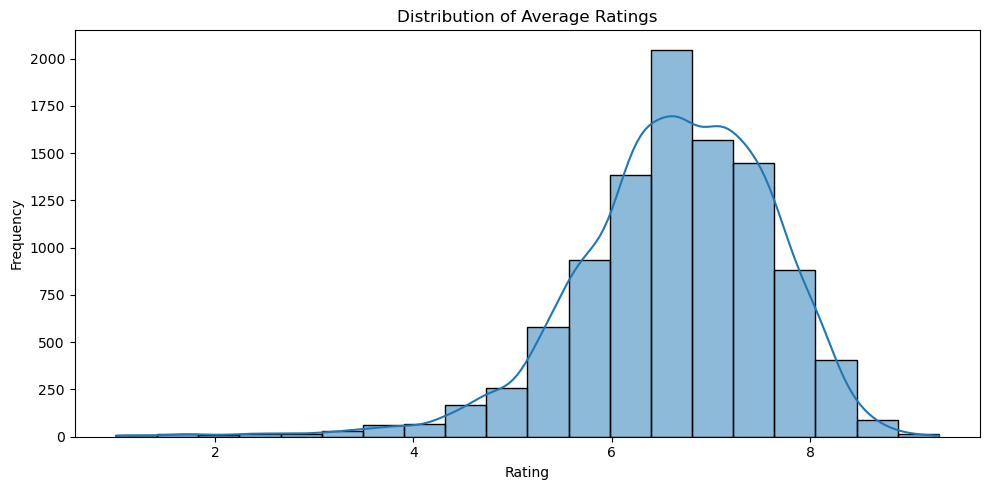

In [20]:
print("\n[DATAFRAME HEAD - FILTERED MOVIES]\n")
print(filtered_movies_df.head(10))

plt.figure(figsize=(10, 5))
sns.histplot(filtered_movies_df['averageRating'], bins=20, kde=True)
plt.title("Distribution of Average Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

- Prints a status message signaling the beginning of user rating simulation.
Extracts all of the distinct genres from the filtered movie dataset and sorts them.
- Creates an empty list to hold the simulated user ratings.
- For each user (1-1000), selects a few liked and disliked genres at random.
- Randomly samples 20 to 50 movies per user and then generates ratings based on matching genres:
Increases rating if liked genres are encountered.
-Lowers ranking if there is a dislike of genres.
- Ranks ratings between 0.5 and 10.0, to one decimal place.
-Stores the obtained results in a DataFrame and saves the file as **simulated_users_ratings.csv**.

https://www.geeksforgeeks.org/python-random-sample-function/
https://www.w3schools.com/python/ref_random_randint.asp
https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html

In [25]:
print("[INFO] Simulating realistic user ratings...")
unique_genres = sorted(set(",".join(filtered_movies_df["genres"]).split(",")))
user_simulated_ratings = []

for user_id in range(1, 1001):
    liked_genres = random.sample(unique_genres, k=random.randint(2, 4))
    disliked_genres = random.sample([g for g in unique_genres if g not in liked_genres], k=random.randint(1, 2))
    sampled_movies = filtered_movies_df.sample(n=random.randint(20, 50), random_state=user_id)

    for _, row in sampled_movies.iterrows():
        genres = row["genres"].split(",")
        rating = np.random.normal(loc=7.0, scale=1.0)
        if any(g in genres for g in liked_genres):
            rating += 1.0
        if any(g in genres for g in disliked_genres):
            rating -= 2.0
        rating = round(min(max(rating, 0.5), 10.0), 1)
        user_simulated_ratings.append({"user_id": user_id, "primaryTitle": row["primaryTitle"], "rating": rating})

user_ratings_df = pd.DataFrame(user_simulated_ratings)
user_ratings_df.to_csv("simulated_users_ratings.csv", index=False)

[INFO] Simulating realistic user ratings...


- Prints a header and shows the first 10 rows of the **user_ratings_df** DataFrame as a preview of the simulated user ratings.
It establishes a new plot figure with dimensions of 10 by 5 inches.
- Plots a histogram of the distribution of user-generated **rating** using **seaborn** with 20 bins and a KDE curve for smoothness.
- Adds a title and axis labels that make the visualization informative and clear.
-Tightens layout spacing with **tight_layout()** and displays the plot with **plt.show()**.



[DATAFRAME HEAD - USER RATINGS]

   user_id                         primaryTitle  rating
0        1                           Encino Man     7.6
1        1                            Pontypool     6.8
2        1                                  Big     9.3
3        1                        Deep Blue Sea     7.8
4        1                             Shehzada     6.7
5        1              The Deaths of Ian Stone     7.2
6        1                                 Edtv     8.1
7        1  Bring Me the Head of Alfredo Garcia     6.8
8        1                       Under the Skin     9.2
9        1                            Fair Game     5.2


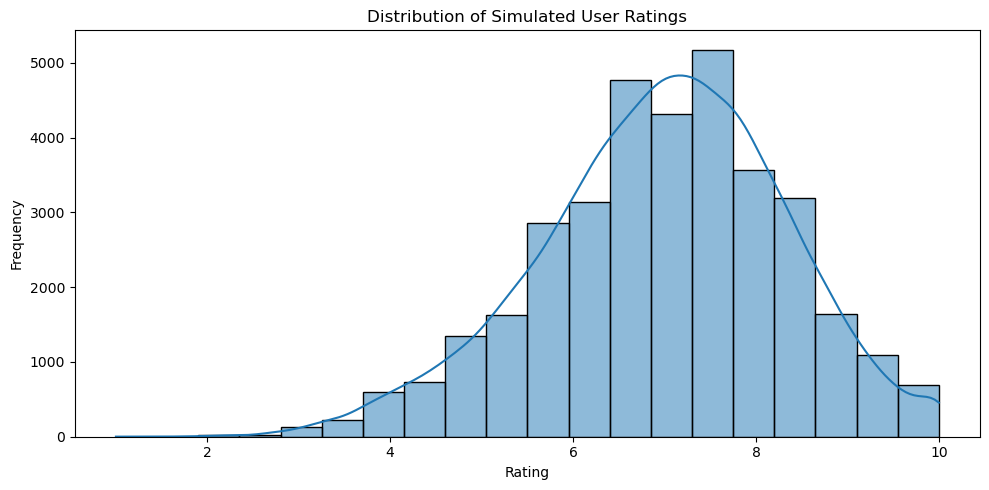

In [28]:
print("\n[DATAFRAME HEAD - USER RATINGS]\n")
print(user_ratings_df.head(10))

plt.figure(figsize=(10, 5))
sns.histplot(user_ratings_df['rating'], bins=20, kde=True)
plt.title("Distribution of Simulated User Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

- Creates a TF-IDF vectorizer to feature-extract from the **genres** column based on the importance of every word within each movie's genres.
- Trains the vectorizer to the genres and converts the text to a numerical feature matrix named **genre_tfidf_matrix**.
- Does the same for the **cast_crew** column but utilizes a different vectorizer for dealing with names of actors and crew.
- Converts this data into **cast_tfidf_matrix**, which facilitates content-based filtering.
These matrices are employed to compute similarity between movies for the purpose of recommendations using text-based metadata.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://www.analyticsvidhya.com/blog/2021/04/difference-between-fit-transform-fit_transform-methods-in-scikit-learn-with-python-code/
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

In [31]:
print("[INFO] Training TF-IDF vectorizers...")
genre_vectorizer = TfidfVectorizer(stop_words="english")
genre_tfidf_matrix = genre_vectorizer.fit_transform(filtered_movies_df["genres"])
cast_vectorizer = TfidfVectorizer(stop_words="english")
cast_tfidf_matrix = cast_vectorizer.fit_transform(filtered_movies_df["cast_crew"].fillna(""))

print("\nTF-IDF Sample Genre Features:\n", genre_vectorizer.get_feature_names_out()[:10])

[INFO] Training TF-IDF vectorizers...

TF-IDF Sample Genre Features:
 ['action' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy']


- Prints a message announcing the training start for the SVD model.
Initializes a **Reader** object from Surprise to specify the rating scale expected
- Transforms the **user_ratings_df** DataFrame into a Surprise-compatible dataset consisting only of user IDs, movie titles, and ratings.
- Splits data into 80/20 ratios for training and test sets through **train_test_split**.
Initializes the **SVD** algorithm (Singular Value Decomposition) for collaborative filtering.
- Trains the model on the training set using fit().
- It evaluates the model on the test set and saves the predicted output to **predictions**.

https://surprise.readthedocs.io/en/stable/reader.html
https://surprise.readthedocs.io/en/stable/getting_started.html#using-a-custom-dataset-from-a-pandas-dataframe
https://surprise.readthedocs.io/en/stable/model_selection.html#train-test-split
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.fit
https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.test

In [34]:
print("[INFO] Training SVD collaborative model...")
reader = Reader(rating_scale=(0.5, 10.0))
surprise_data = Dataset.load_from_df(user_ratings_df[["user_id", "primaryTitle", "rating"]], reader)
trainset, testset = train_test_split(surprise_data, test_size=0.2)
svd_model = SVD()
svd_model.fit(trainset)
predictions = svd_model.test(testset)

[INFO] Training SVD collaborative model...


- Prints a message that signifies the initiation of rating prediction evaluation.
- Calculates and prints the **Root Mean Squared Error (RMSE)**, which is a measurement for how far apart the predicted ratings are from observed ratings.
- Computes and prints **Mean Absolute Error (MAE)**, which is the average absolute difference between actual ratings and predicted ratings.
These statistics are used to evaluate the correctness and reliability of the collaborative filtering model created based on the SVD algorithm.

https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.mae
https://surprise.readthedocs.io/en/stable/accuracy.html

In [37]:
print("\n[INFO] Rating Prediction Evaluation")
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))


[INFO] Rating Prediction Evaluation
RMSE: 1.2922
RMSE: 1.2921899950938653
MAE:  1.0275
MAE: 1.0275190961963159


- Creates a function that computes **Precision@10** and **Recall@10** for every user using the predicted and actual ratings.
- Orders predictions by predicted rating and selects items that are above a threshold set by you (default 7.5).
- Calculates the number of relevant items it suggested (precision) and the number of relevant items it identified (recall).
- Specifies an additional function to calculate **nDCG@10** that assesses the quality of ranked recommendations.
- Calculates and prints the average **Precision**, **Recall**, and **nDCG** over all users to evaluate recommendation quality.

https://scikit-learn.org/stable/api/sklearn.metrics.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

https://docs.python.org/3/library/collections.html

In [40]:
def precision_recall_at_k(predictions, k=10, threshold=7.5):
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))
    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        num_relevant = sum((true >= threshold) for (_, true) in user_ratings)
        num_rec_k = sum((est >= threshold) for (est, _) in top_k)
        num_rel_and_rec = sum(((true >= threshold) and (est >= threshold)) for (est, true) in top_k)
        precisions[uid] = num_rel_and_rec / k
        recalls[uid] = num_rel_and_rec / num_relevant if num_relevant else 0
    return precisions, recalls

def compute_ndcg(predictions, k=10):
    scores_est = defaultdict(list)
    scores_true = defaultdict(list)
    for pred in predictions:
        scores_est[pred.uid].append(pred.est)
        scores_true[pred.uid].append(pred.r_ui)
    ndcg_scores = []
    for uid in scores_est:
        if len(scores_est[uid]) < k:
            continue
        est = np.asarray([scores_est[uid]])
        true = np.asarray([scores_true[uid]])
        ndcg_scores.append(ndcg_score(true, est, k=k))
    return np.mean(ndcg_scores)

p, r = precision_recall_at_k(predictions)
print("[EVAL] Precision@10:", np.mean(list(p.values())))
print("[EVAL] Recall@10:", np.mean(list(r.values())))
print("[EVAL] NDCG@10:", compute_ndcg(predictions))

[EVAL] Precision@10: 0.033099297893681046
[EVAL] Recall@10: 0.08551212801463555
[EVAL] NDCG@10: 0.9224347534628399


- Prints a message indicating the start of the model-saving process.
- Saves the **genre_vectorizer** and **cast_vectorizer** to **.pkl** files for future text feature extraction.
- Saves the trained **SVD model** for reuse in generating recommendations.
- Saves the cleaned and filtered **movies DataFrame**.
- Saves the computed **TF-IDF matrices** for genres and cast to disk.
- All artifacts are stored in the **models/** directory, allowing the system to be reloaded without retraining or reprocessing.

https://joblib.readthedocs.io/en/latest/generated/joblib.dump.html

In [43]:
print("[INFO] Saving models...")
joblib.dump(genre_vectorizer, "models/genre_vectorizer.pkl")
joblib.dump(cast_vectorizer, "models/cast_vectorizer.pkl")
joblib.dump(svd_model, "models/svd_model.pkl")
joblib.dump(filtered_movies_df, "models/movies_df.pkl")
joblib.dump(genre_tfidf_matrix, "models/genre_tfidf_matrix.pkl")
joblib.dump(cast_tfidf_matrix, "models/cast_tfidf_matrix.pkl")

print("[INFO] All models saved to 'models/' folder.")

[INFO] Saving models...
[INFO] All models saved to 'models/' folder.
